In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import recog_l3
import os 

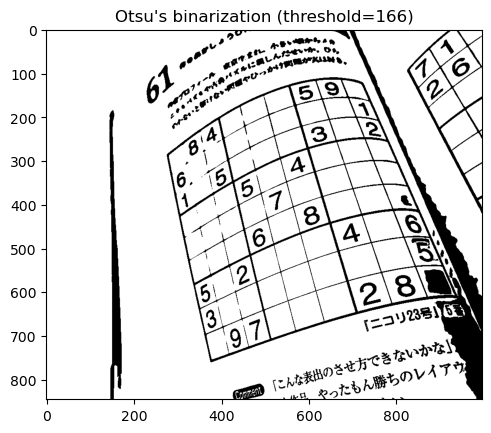

In [31]:
# image = cv2.imread("./data/level3/sample.jpg", cv2.IMREAD_COLOR)
num=15
image = cv2.imread(f"./data/level3/sudoku_000{num}.jpg", cv2.IMREAD_COLOR)
# num=26
# image = cv2.imread(f"./data/level1/sudoku_0{num}.jpg", cv2.IMREAD_COLOR)
# image = cv2.imread(f"./data/level2/sample.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
trim_percentage=0.002
height, width, channels = image.shape[:3]
trim_width = int(width * trim_percentage)
trim_height = int(height * trim_percentage)
image = image[trim_height:height - trim_height, trim_width:width - trim_width]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray= cv2.bilateralFilter(gray, 11, 2,2)
# gray_gb = cv2.GaussianBlur(gray, None, 2.0)
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(100,100))
gray = clahe.apply(gray)
# gray = cv2.equalizeHist(gray)
# ぼかし処理


# gray_gb =cv2.medianBlur(gray_gb, 5)
gray = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
# 大津の二値化

thr, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
new_thr = min(int(thr * 1.05), 255)
_, binary = cv2.threshold(gray, new_thr, 255, cv2.THRESH_BINARY)
plt.imshow(binary, cmap="gray")
plt.title("Otsu's binarization (threshold={:d})".format(int(thr)))
plt.show()

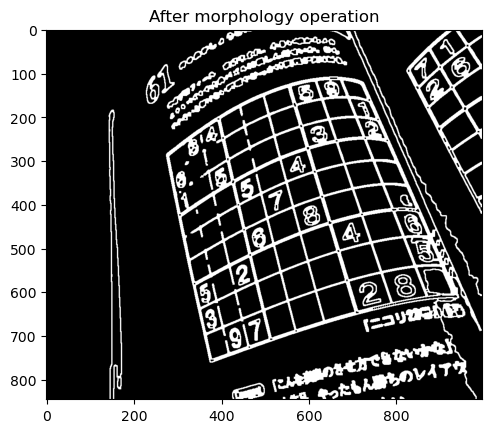

In [32]:
edge = cv2.Canny(binary, 100, 200)
edge = cv2.dilate(edge, np.ones((5, 5), dtype=edge.dtype),iterations=1)
edge = cv2.erode(edge, np.ones((3, 3), dtype=edge.dtype),iterations=1)
# res_close = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 5), dtype=binary.dtype))
plt.imshow(edge, cmap="gray")
plt.title("After morphology operation".format(thr))
plt.show()

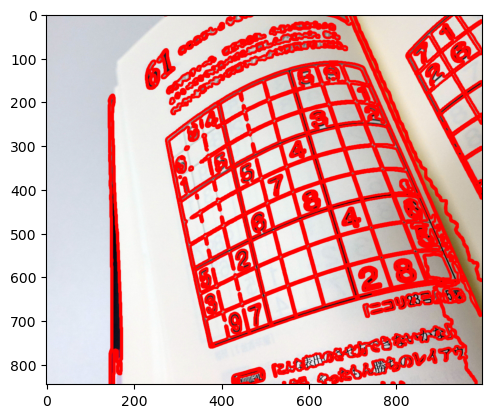

In [33]:
contours, _ = cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
result = image.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.show()
# x, y, w, h = cv2.boundingRect(contours[1])
# cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
# plt.imshow(image)
# plt.show()

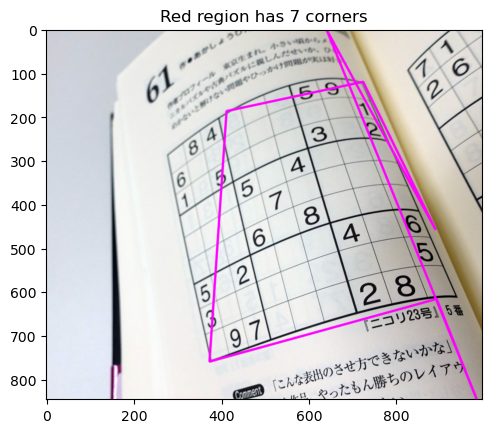

7


In [34]:
longest_cnt = None
max_length = 0.0
max_area = 0.0
result = image.copy()
epsilon=3e-2
for cnt in contours:
    # 輪郭線の長さを計算
    arclen = cv2.arcLength(cnt, True)
    approx=cv2.approxPolyDP(cnt, arclen *epsilon, True)
    area=cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(approx)
    internal_area_ratio = area / (w * h)
    if len(approx)<10 and len(approx) >= 4 and internal_area_ratio>0.5:
        # print(len(approx), x,y,w,h, arclen,internal_area_ratio)
        cv2.drawContours(result, [approx], -1, (255, 0, 0), 3, cv2.LINE_AA)
        # plt.imshow(result)
        # plt.show()
        if  max_area < area:
            max_area = area
            max_length = arclen
            longest_cnt = cnt
result = image.copy()
tmp=image.copy()

# plt.imshow(result)
# plt.show()
# print(len(longest_cnt))
arclen = cv2.arcLength(longest_cnt, True)
approx = cv2.approxPolyDP(longest_cnt, arclen * epsilon, True) 
cv2.drawContours(tmp, [approx], -1, (255, 0, 255), 3, cv2.LINE_AA)
plt.imshow(tmp)
plt.title("Red region has {:d} corners".format(len(approx)))
plt.show()
print(len(approx))

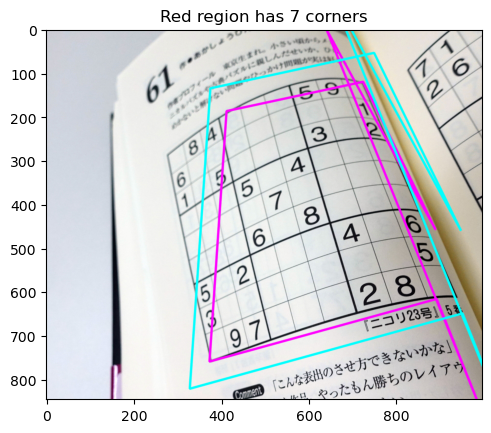

In [35]:
# 輪郭線の重心を計算する
M = cv2.moments(approx)
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])

# 各点に対して、重心からの距離を計算し、1.1倍した点を取得する
new_approx = []
for point in approx:
    x, y = point[0]
    dist = np.sqrt((cx - x)**2 + (cy - y)**2)
    dist_new = dist * 1.2
    x_new = int(cx - dist_new * (cx - x) / dist)
    y_new = int(cy - dist_new * (cy - y) / dist)
    new_approx.append([[x_new, y_new]])

# 新しい近似を描画する
new_approx = np.array(new_approx)
cv2.drawContours(tmp, [np.array(new_approx)], -1, (0, 255, 255), 3, cv2.LINE_AA)
plt.imshow(tmp)
plt.title("Red region has {:d} corners".format(len(new_approx)))
plt.show()

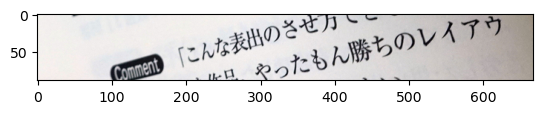

[[  47.  224.]
 [ 320.    0.]
 [ 421.  143.]
 [ 619.  548.]
 [ 623.  738.]
 [ 732. 1012.]
 [   0.  910.]]


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:3528: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'cv::getPerspectiveTransform'


In [36]:
# さっきのところを切り取って射影変換    
x, y, w, h = cv2.boundingRect(new_approx)
cropped = image[y:y+h, x:x+w]
plt.imshow(cropped)
plt.show()
# print(approx)
new_approx=new_approx-(x,y)
src_pts = new_approx.reshape((-1, 2)).astype("float32")
center = np.mean(src_pts, axis=0)
# ４点を重心からの角度でソートする
# 時計回りになる
src_pts = np.array(sorted(src_pts, key=lambda p: np.arctan2(p[1]-center[1], p[0]-center[0])))

# 結果を表示する
print(src_pts)
# 縦横比の計算
w = np.linalg.norm(src_pts[3] - src_pts[0])
h = np.linalg.norm(src_pts[1] - src_pts[0])
aspect = abs(w) / abs(h)

# 新しい画像サイズを設定
new_w = int(1000*aspect)
# new_w = 1000
new_h = 1000
# dst_pts = np.array([(0, 0), (0, new_h), (new_w, new_h), (new_w, 0)], dtype="float32")
dst_pts = np.array([(0, 0), (new_w, 0), (new_w, new_h), (0, new_h)], dtype="float32")

# 射影変換を計算して、パースをキャンセルする
warp = cv2.getPerspectiveTransform(src_pts, dst_pts)
result = cv2.warpPerspective(cropped, warp, (new_w, new_h))

#　反転させたリストを作成
# results=[result, cv2.rotate(result,cv2.ROTATE_90_CLOCKWISE), cv2.rotate(result,cv2.ROTATE_180), cv2.rotate(result,cv2.ROTATE_90_COUNTERCLOCKWISE)]
# for i, result in enumerate(results):

#     plt.subplot(2, 2, i+1)
#     plt.imshow(result)
#     plt.title("result {:d}".format(i))
# result=cv2.rotate(result,cv2.ROTATE_90_CLOCKWISE)
plt.imshow(result, cmap="gray")
plt.show()

77


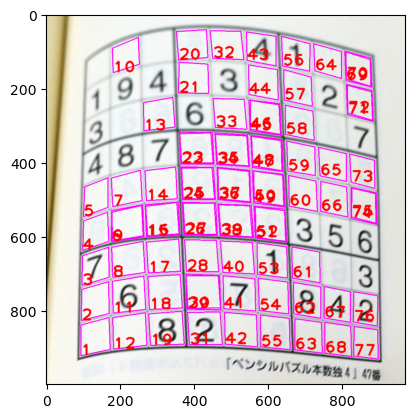

In [ ]:
def is_square(sides):
    
    # 輪郭の面積と外接矩形の面積を比較
    area = cv2.contourArea(cnt)
    rect_area = sides[0]*sides[1]
    side_ratio=(sides[1]+sides[3])/(sides[0]+sides[2])
    if side_ratio>2.5 or side_ratio<0.5:
        return False
    if area / rect_area < 0.2 or area / rect_area > 4:
        return False
    return True

n_close,n_open=2,2
n_dilate,n_erode=2,1
# 正方形を検出する
# 画像をグレースケールに変換する

gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
gray= cv2.bilateralFilter(gray, 11, 2,2)
# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=.5, tileGridSize=(10,10))
for i in range(10):
    gray = clahe.apply(gray)

# # Apply denoising
gray = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)

# 大津の二値化を適用
thresh, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
new_thr = min(int(thresh * 1.05), 255)
_, binary = cv2.threshold(gray, new_thr, 255, cv2.THRESH_BINARY)
edge = cv2.Canny(binary, 100, 200)
edge = cv2.dilate(edge, np.ones((5, 5), dtype=edge.dtype))
edge = cv2.erode(edge, np.ones((3, 3), dtype=edge.dtype))
# 輪郭を検出する
contours, hierarchy = cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# plt.imshow(binary, cmap="gray")
# plt.show()
# 正方形を検出する
res2 = result.copy()
count=0
# contours=sorted(contours, key=lambda x:x[0][0][0])
contours=sorted(contours, key=lambda c: (cv2.boundingRect(c)[0], cv2.boundingRect(c)[1]))
# contours=sorted(contours, key=lambda x:x[0][0][1])
squares=[]
for cnt in contours:
    # 輪郭線の近似を行う
    arclen = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, arclen * 6e-2, True)
    if len(approx) == 4:

        # 各辺の長さを計算する
        sides = []
        points = []
        for i in range(4):
            x1, y1 = approx[i][0]
            x2, y2 = approx[(i + 1) % 4][0]
            side = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            points.append([x1, y1])
            sides.append(side)
        points=sorted(points, key=lambda x:x[0])
        if points[0][1]<points[1][1]:
            points[0],points[1]=points[1],points[0]
        
        # 各辺の長さがほぼ等しい場合、正方形とみなす
        # if np.std(sides) < np.mean(sides) :
        if is_square(sides):
            if max(sides) >= result.shape[0] /18*2.7 or min(sides) <= result.shape[0] / 18:
                continue
            # if min(sides) <= result.shape[0] / 9:
                
            cv2.drawContours(res2, [approx], -1, (255,0,255), 2)
            # put number
            count+=1
            squares.append(approx)
            cv2.putText(res2, str(count), (points[0][0],points[0][1]), cv2.FONT_HERSHEY_PLAIN, 3, (255,0,0), 3, cv2.LINE_AA)
print(count)
plt.imshow(res2)

(215, 111)
(304, 271)
(405, 362)
(409, 457)
(414, 553)
(419, 653)
(424, 750)
(428, 849)
(618, 860)
1 7
1 8
2 7
2 8
3 7
3 8
4 6
4 7
4 8
5 4
5 5
5 6
5 7
5 8
6 4
6 5
6 6
6 7
6 8
7 3
7 4
7 5
7 6
7 7
7 8
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8


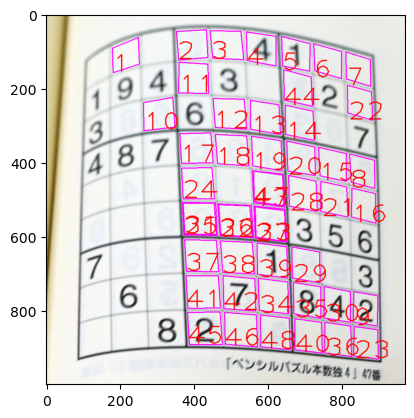

In [ ]:
# contoursのソート
# 左上の輪郭を取得する
top_left = None
init_squares=squares
# 重心
centers = []
# 重心と輪郭の対応
cen2contours={}

for cnt in squares:
    M = cv2.moments(cnt)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    centers.append((cx, cy))
    cen2contours[(cx, cy)]=cnt
not_visited=set(center for center in centers)

# 左上の輪郭を取得する
top_left = min(centers, key=lambda s: s[0] + s[1])
not_visited.remove(top_left)
squares=[[top_left]]
# 左上の輪郭の中でy軸方向に近い順に8つの輪郭を選択する
current_pos = top_left
for i in range(8):
    min_dist = float('inf')
    next_square = None
    for cnt in not_visited:
        x,y=cnt
        dist= np.sqrt((x - current_pos[0])**2 + (y - current_pos[1])**2)
        if dist < min_dist and y > current_pos[1]+5:
            min_dist = dist
            next_square = cnt
    if next_square is not None:
        squares.append([next_square])
        current_pos = next_square
        not_visited.remove(next_square)
# 各輪郭に対してx軸方向に近い順に8つの輪郭を選択する
res3 = result.copy()
count = 0
# print(squares)

for i in range(9):
    left_most = squares[i][0]
    print(left_most)
    current_pos = left_most
    for j in range(8):
        min_dist = float('inf')
        next_square = None
        for cnt in not_visited:
            x, y=cnt
            # dist = abs(y - current_pos[1])
            dist= np.sqrt((x - current_pos[0])**2 + (y - current_pos[1])**2)
            if dist < min_dist and x > current_pos[0]+5:
                min_dist = dist
                next_square = cnt
        if next_square is not None:
            squares[i].append(next_square)
            current_pos = next_square
            not_visited.remove(next_square)
for i in range(9):
    for j in range(9):
        try:
            cx,cy= squares[i][j]
        except IndexError:
            print(i,j)
            continue
        cnt=cen2contours[(cx,cy)]
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.drawContours(res3, [cnt], -1, (255,0,255), 2)
        count += 1
        cv2.putText(res3, str(count), (x, y+h), cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), 2, cv2.LINE_AA)
plt.imshow(res3)

In [ ]:
problem=np.zeros((9,9))
pixel=20
white_thres=250
# scaler = pd.read_pickle('./models/Rand_numbers_mix_l2_scaler.pickle')
scaler = pd.read_pickle('./models/MLPC_numbers_mix_scaler.pickle')
# clf = pd.read_pickle('./models/Rand_numbers_mix_l2_clf.pickle')
clf=pd.read_pickle('./models/MLPC_numbers_mix_clf.pickle')
for i in range(9):
    for j in range(9):
        cnt=cen2contours[squares[i][j]]
        x, y, w, h = cv2.boundingRect(cnt)
        cropped = result[y:y+h, x:x+w]
        # plt.imshow(cropped)
        # plt.show()
        # print(approx)
        cnt=cnt-(x,y)
        src_pts = cnt.reshape((-1, 2)).astype("float32")
        center = np.mean(src_pts, axis=0)
        # ４点を重心からの角度でソートする
        # 時計回りになる
        src_pts = np.array(sorted(src_pts, key=lambda p: np.arctan2(p[1]-center[1], p[0]-center[0])))

        # 結果を表示する
        # print(src_pts)
        # 縦横比の計算
        w = np.linalg.norm(src_pts[3] - src_pts[0])
        h = np.linalg.norm(src_pts[1] - src_pts[0])
        aspect = abs(w) / abs(h)

        # 新しい画像サイズを設定
        new_w = int(1000*aspect)
        # new_w = 1000
        new_h = 1000
        # dst_pts = np.array([(0, 0), (0, new_h), (new_w, new_h), (new_w, 0)], dtype="float32")
        dst_pts = np.array([(0, 0), (new_w, 0), (new_w, new_h), (0, new_h)], dtype="float32")

        # 射影変換を計算して、パースをキャンセルする
        warp = cv2.getPerspectiveTransform(src_pts, dst_pts)
        res4 = cv2.warpPerspective(cropped, warp, (new_w, new_h))
        res4=cv2.cvtColor(res4, cv2.COLOR_RGB2GRAY)
        thr, res4 = cv2.threshold(res4, 0, 255, cv2.THRESH_OTSU)
        res4=cv2.resize(res4, (pixel,pixel), interpolation=cv2.INTER_AREA)
        digit_square = res4
        if np.mean(digit_square)>=white_thres:
            problem[i][j]=0
            continue
        digit_square = digit_square.reshape(1, -1)/255.0
        digit_square=scaler.transform(digit_square)
        prediction = clf.predict(digit_square)
        # predicted_digit = np.argmax(prediction)
        problem[i][j]=prediction[0]
problem

IndexError: list index out of range